In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
df = pd.read_csv("kbo_dataset_2018_2024.csv")
df.head()


,player_name,team,year,home_run_rate,label,batting_side,throwing_hand,height,weight,age,...,batting_avg,onbase_perc,slugging_perc,IBB,onbase_plus_slugging,TB,GIDP,HBP,SH,SF
0,Chi Hong An,Kia Tigers,2018,0.041894,Kia Tigers-2018-Chi Hong An,R,R,"5' 10""",194,27,...,0.342,0.392,0.563,1,0.954,278,13,10,0,9
1,Yong Hwan Baik,Kia Tigers,2018,0.000000,Kia Tigers-2018-Yong Hwan Baik,R,R,"5' 10""",209,29,...,0.277,0.393,0.298,0,0.691,14,3,0,1,0
2,Roger Bernadina,Kia Tigers,2018,0.033898,Kia Tigers-2018-Roger Bernadina,L,L,"6' 2""",210,34,...,0.310,0.395,0.487,3,0.883,250,9,10,3,1
3,Hyoung Woo Choi,Kia Tigers,2018,0.041051,Kia Tigers-2018-Hyoung Woo Choi,L,R,"5' 10""",233,34,...,0.339,0.414,0.549,7,0.963,290,17,7,0,8
4,Jung Min Choi,Kia Tigers,2018,0.021053,Kia Tigers-2018-Jung Min Choi,L,R,"5' 9""",158,29,...,0.253,0.319,0.349,0,0.668,29,2,1,4,0


In [3]:
# Calculate WAR using custom formula
df['WAR'] = (df['onbase_plus_slugging'].fillna(0) * df['PA'].fillna(0) +
             (df['SB'].fillna(0) - df['CS'].fillna(0)) * 0.2 +
             df['BB'].fillna(0) * 0.05 -
             df['SO'].fillna(0) * 0.02) / 100


In [4]:
# Convert height to inches
df['height_in'] = df['height'].apply(lambda x: int(x.split("'")[0]) * 12 + int(x.split("'")[1].replace('"','').strip()) if isinstance(x, str) and "'" in x else np.nan)

# Define count and ratio features
count_cols = ['HR', 'BB', 'SB', 'H', 'RBI', 'G', 'PA', 'SO', 'CS']
ratio_cols = ['batting_avg', 'onbase_perc', 'slugging_perc', 'onbase_plus_slugging']

# Fill count features with 0, ratio features with mean
df[count_cols] = df[count_cols].fillna(0)
for col in ratio_cols:
    df[col] = df[col].fillna(df[col].mean())

# Drop rows where key values are still missing
df.dropna(subset=['WAR', 'height_in'], inplace=True)


In [5]:
features = ['age', 'weight', 'G', 'PA', 'H', 'HR', 'RBI', 'SB', 'BB', 'SO', 'CS',
            'batting_avg', 'onbase_perc', 'slugging_perc', 'onbase_plus_slugging', 'height_in']
target = 'WAR'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


In [6]:
print("[Linear Regression]")
print(f"MAE: {mean_absolute_error(y_test, lr_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, lr_pred):.4f}")
print(f"R^2: {r2_score(y_test, lr_pred):.4f}\n")

print("[Random Forest Regression]")
print(f"MAE: {mean_absolute_error(y_test, rf_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, rf_pred):.4f}")
print(f"R^2: {r2_score(y_test, rf_pred):.4f}")


[Linear Regression]
MAE: 0.0368
MSE: 0.0032
R^2: 0.9987

[Random Forest Regression]
MAE: 0.0370
MSE: 0.0045
R^2: 0.9982


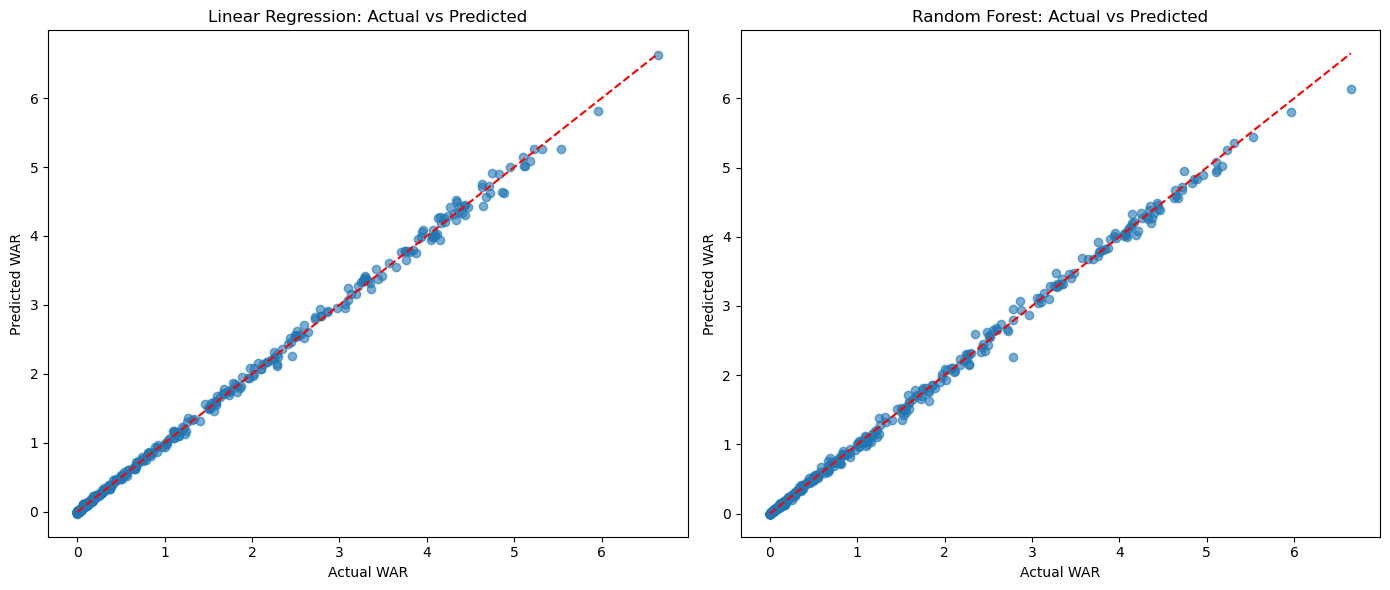

In [7]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual WAR')
plt.ylabel('Predicted WAR')

plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual WAR')
plt.ylabel('Predicted WAR')

plt.tight_layout()
plt.show()


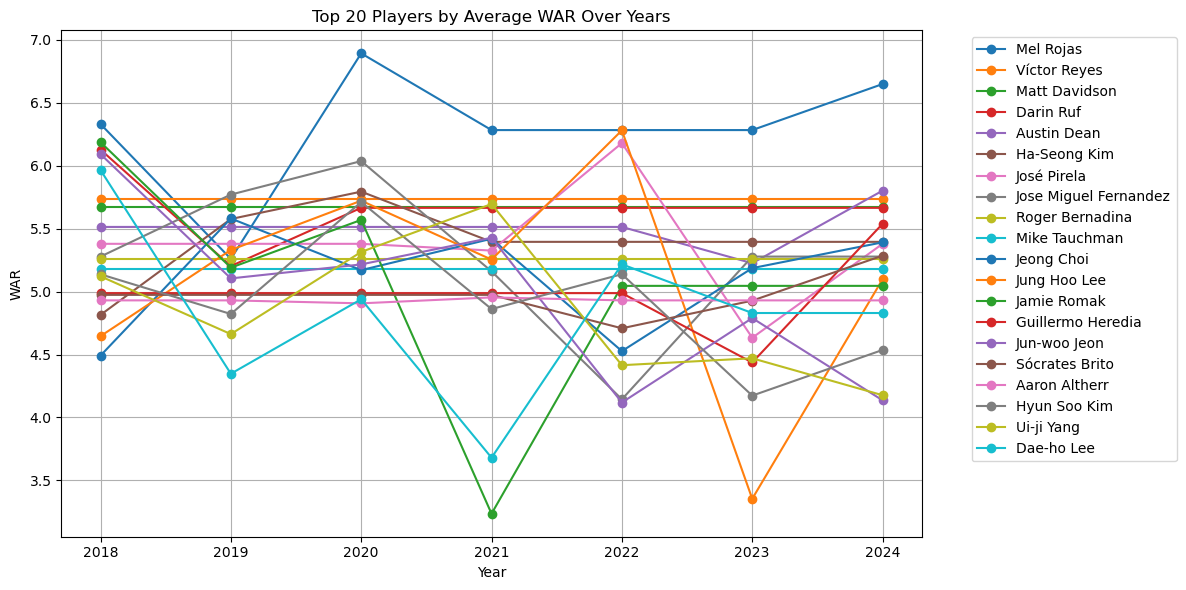

In [8]:
pivot = df.pivot_table(index='player_name', columns='year', values='WAR', aggfunc='mean')
pivot = pivot.dropna(how='all')
pivot = pivot.apply(lambda row: row.fillna(row.mean()), axis=1)

pivot_top20 = pivot.mean(axis=1).sort_values(ascending=False).head(20)
pivot_top20_df = pivot.loc[pivot_top20.index]

pivot_top20_df.T.plot(figsize=(12, 6), marker='o')
plt.title("Top 20 Players by Average WAR Over Years")
plt.xlabel("Year")
plt.ylabel("WAR")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
#Mel Jojas 2020년도 홈런, 타점 1위, 타율 3위(타율은 .349로 1위와 0.005 차이) ; 리그 MVP